<a href="https://colab.research.google.com/github/jominjose14/SleepyWheels/blob/main/EfficientNet_for_Sleepy_Face_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Downgrade pillow to avoid `UserWarning: Possibly corrupt EXIF data.`
!pip install pillow==4.0.0

     |████████████████████████████████| 11.1MB 7.2MB/s 
     |████████████████████████████████| 112kB 61.6MB/s 
  Created wheel for pillow: filename=Pillow-4.0.0-cp37-cp37m-linux_x86_64.whl size=1007423 sha256=b20a82b8af8e08c7a55d565c8c35bf9397286ffa5980b55df1ae7bb51e904200
  Stored in directory: /root/.cache/pip/wheels/4f/0a/2a/7e3391063af230fac4b5fdb4cc93adcb1d99af325b623cea03
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35416 sha256=6b782f6be5bc5f4b268c4e7477ec411773667789c08677e6325a4612cadc072c
  Stored in directory: /root/.cache/pip/wheels/4b/f4/11/bc4166107c27f07fd7bba707ffcb439619197638a1ac986df3
Successfully built pillow olefile
ERROR: torchvision 0.9.1+cu101 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.16.2 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: bokeh 2.3.2 has requirement pillow>=7.1.0, but you'll have pillow 4.0.0 which is incompatib

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow.keras
print(tensorflow.__version__)
print(tensorflow.keras.__version__)

1.15.2
2.2.4-tf


In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

## **Hyperparameters**

In [ ]:
batch_size = 64

width = 150
height = 150
epochs = 50
NUM_TRAIN = 2103
NUM_TEST = 400
dropout_rate = 0.4
input_shape = (height, width, 3)

In [ ]:
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
  !git clone https://github.com/Tony607/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
/content/efficientnet_keras_transfer_learning


In [ ]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

Using TensorFlow backend.


In [ ]:
# loading pretrained conv base model
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [ ]:
train_data_dir = '/content/drive/MyDrive/Sleepy or Awake Faces - Dataset/train'
validation_data_dir = '/content/drive/MyDrive/Sleepy or Awake Faces - Dataset/validation'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_data_dir,
        # All images will be resized to target height and width.
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='binary')

Found 2103 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(1, activation='sigmoid', name="fc_out"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 5, 5, 1280)        4049564   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               327936    
_________________________________________________________________
fc_out (Dense)               (None, 1)                 257       
Total params: 4,377,757
Trainable params: 4,335,741
Non-trainable params: 42,016
_________________________________________

### **Freezing the Conv Layers**

In [ ]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 215
This is the number of trainable layers after freezing the conv base: 4


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 5, 5, 1280)        4049564   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               327936    
_________________________________________________________________
fc_out (Dense)               (None, 1)                 257       
Total params: 4,377,757
Trainable params: 328,193
Non-trainable params: 4,049,564
________________________________________

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['binary_accuracy'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
19/32 [================>.............] - ETA: 2:47 - loss: 1.4906 - binary_accuracy: 0.5115

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 460s 14s/step - loss: 1.4521 - binary_accuracy: 0.5213 - val_loss: 0.9424 - val_binary_accuracy: 0.5677
Epoch 2/50
13/32 [===========>..................] - ETA: 10s - loss: 1.2271 - binary_accuracy: 0.5204

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


21/32 [==================>...........] - ETA: 6s - loss: 1.2390 - binary_accuracy: 0.5290

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 649ms/step - loss: 1.2208 - binary_accuracy: 0.5439 - val_loss: 0.9188 - val_binary_accuracy: 0.5859
Epoch 3/50
 8/32 [======>.......................] - ETA: 14s - loss: 1.1479 - binary_accuracy: 0.5566

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


14/32 [============>.................] - ETA: 9s - loss: 1.1906 - binary_accuracy: 0.5413 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 655ms/step - loss: 1.2008 - binary_accuracy: 0.5493 - val_loss: 0.9121 - val_binary_accuracy: 0.6068
Epoch 4/50
 7/32 [=====>........................] - ETA: 11s - loss: 1.2129 - binary_accuracy: 0.5330

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 652ms/step - loss: 1.1265 - binary_accuracy: 0.5738 - val_loss: 0.9205 - val_binary_accuracy: 0.6172
Epoch 5/50
10/32 [========>.....................] - ETA: 11s - loss: 1.0843 - binary_accuracy: 0.5891

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


31/32 [============================>.] - ETA: 0s - loss: 1.0728 - binary_accuracy: 0.5995

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


Epoch 1/50
32/32 [==============================] - 21s 645ms/step - loss: 1.0727 - binary_accuracy: 0.6003 - val_loss: 0.8248 - val_binary_accuracy: 0.6536
Epoch 6/50
13/32 [===========>..................] - ETA: 8s - loss: 1.0420 - binary_accuracy: 0.6250

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 646ms/step - loss: 0.9931 - binary_accuracy: 0.6219 - val_loss: 0.7792 - val_binary_accuracy: 0.6615
Epoch 7/50
 6/32 [====>.........................] - ETA: 2s - loss: 0.9208 - binary_accuracy: 0.6406

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


10/32 [========>.....................] - ETA: 8s - loss: 0.9715 - binary_accuracy: 0.6422

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 652ms/step - loss: 0.9624 - binary_accuracy: 0.6351 - val_loss: 0.7834 - val_binary_accuracy: 0.6562
Epoch 8/50
11/32 [=========>....................] - ETA: 7s - loss: 0.9524 - binary_accuracy: 0.6321

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 654ms/step - loss: 0.8851 - binary_accuracy: 0.6459 - val_loss: 0.7711 - val_binary_accuracy: 0.6562
Epoch 9/50
 5/32 [===>..........................] - ETA: 2s - loss: 0.8675 - binary_accuracy: 0.6375

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


14/32 [============>.................] - ETA: 6s - loss: 0.8780 - binary_accuracy: 0.6473

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


23/32 [====================>.........] - ETA: 3s - loss: 0.8971 - binary_accuracy: 0.6365

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 19s 609ms/step - loss: 0.8960 - binary_accuracy: 0.6356 - val_loss: 0.7467 - val_binary_accuracy: 0.6771
Epoch 10/50
22/32 [===================>..........] - ETA: 4s - loss: 0.8481 - binary_accuracy: 0.6733

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 655ms/step - loss: 0.8491 - binary_accuracy: 0.6641 - val_loss: 0.7820 - val_binary_accuracy: 0.6641
Epoch 11/50
 9/32 [=======>......................] - ETA: 4s - loss: 0.8613 - binary_accuracy: 0.6510

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


20/32 [=================>............] - ETA: 5s - loss: 0.7987 - binary_accuracy: 0.6672

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


31/32 [============================>.] - ETA: 0s - loss: 0.7822 - binary_accuracy: 0.6658

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


Epoch 1/50
32/32 [==============================] - 20s 616ms/step - loss: 0.7835 - binary_accuracy: 0.6655 - val_loss: 0.7715 - val_binary_accuracy: 0.6719
Epoch 12/50
19/32 [================>.............] - ETA: 5s - loss: 0.7387 - binary_accuracy: 0.6943

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 661ms/step - loss: 0.7768 - binary_accuracy: 0.6877 - val_loss: 0.7407 - val_binary_accuracy: 0.6901
Epoch 13/50
12/32 [==========>...................] - ETA: 4s - loss: 0.8206 - binary_accuracy: 0.6771

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


22/32 [===================>..........] - ETA: 4s - loss: 0.8035 - binary_accuracy: 0.6762

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 20s 609ms/step - loss: 0.8082 - binary_accuracy: 0.6768 - val_loss: 0.7353 - val_binary_accuracy: 0.6823
Epoch 14/50
28/32 [=========================>....] - ETA: 1s - loss: 0.7978 - binary_accuracy: 0.6674

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


31/32 [============================>.] - ETA: 0s - loss: 0.7916 - binary_accuracy: 0.6714Epoch 1/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 652ms/step - loss: 0.7952 - binary_accuracy: 0.6714 - val_loss: 0.7379 - val_binary_accuracy: 0.6875
Epoch 15/50
30/32 [===========================>..] - ETA: 0s - loss: 0.7828 - binary_accuracy: 0.6766

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 641ms/step - loss: 0.7776 - binary_accuracy: 0.6793 - val_loss: 0.6872 - val_binary_accuracy: 0.7083
Epoch 16/50
 4/32 [==>...........................] - ETA: 3s - loss: 0.8518 - binary_accuracy: 0.6758

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


24/32 [=====================>........] - ETA: 3s - loss: 0.7380 - binary_accuracy: 0.6979

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 657ms/step - loss: 0.7455 - binary_accuracy: 0.6929 - val_loss: 0.7128 - val_binary_accuracy: 0.7057
Epoch 17/50
23/32 [====================>.........] - ETA: 3s - loss: 0.7797 - binary_accuracy: 0.6816

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


31/32 [============================>.] - ETA: 0s - loss: 0.7726 - binary_accuracy: 0.6923

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


Epoch 1/50
32/32 [==============================] - 20s 619ms/step - loss: 0.7725 - binary_accuracy: 0.6887 - val_loss: 0.7142 - val_binary_accuracy: 0.6927
Epoch 18/50
28/32 [=========================>....] - ETA: 1s - loss: 0.7089 - binary_accuracy: 0.7020

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 20s 631ms/step - loss: 0.7061 - binary_accuracy: 0.7031 - val_loss: 0.7687 - val_binary_accuracy: 0.6693
Epoch 19/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


 4/32 [==>...........................] - ETA: 23s - loss: 0.7025 - binary_accuracy: 0.7070

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 671ms/step - loss: 0.7463 - binary_accuracy: 0.6876 - val_loss: 0.7074 - val_binary_accuracy: 0.6953
Epoch 20/50
31/32 [============================>.] - ETA: 0s - loss: 0.6980 - binary_accuracy: 0.6942

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


Epoch 1/50
32/32 [==============================] - 20s 632ms/step - loss: 0.6966 - binary_accuracy: 0.6940 - val_loss: 0.6692 - val_binary_accuracy: 0.7109
Epoch 21/50
32/32 [==============================] - 20s 628ms/step - loss: 0.6781 - binary_accuracy: 0.7146 - val_loss: 0.7324 - val_binary_accuracy: 0.6849
Epoch 22/50
13/32 [===========>..................] - ETA: 6s - loss: 0.6952 - binary_accuracy: 0.7035

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


17/32 [==============>...............] - ETA: 5s - loss: 0.6928 - binary_accuracy: 0.7090

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


21/32 [==================>...........] - ETA: 4s - loss: 0.7093 - binary_accuracy: 0.7011

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 644ms/step - loss: 0.7105 - binary_accuracy: 0.6995 - val_loss: 0.7403 - val_binary_accuracy: 0.6641
Epoch 23/50
13/32 [===========>..................] - ETA: 6s - loss: 0.6276 - binary_accuracy: 0.7200

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


31/32 [============================>.] - ETA: 0s - loss: 0.6570 - binary_accuracy: 0.7107Epoch 1/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 646ms/step - loss: 0.6564 - binary_accuracy: 0.7090 - val_loss: 0.7311 - val_binary_accuracy: 0.6771
Epoch 24/50
31/32 [============================>.] - ETA: 0s - loss: 0.6748 - binary_accuracy: 0.7096Epoch 1/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


 1/32 [..............................] - ETA: 1:11 - loss: 0.5937 - binary_accuracy: 0.7344

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 20s 637ms/step - loss: 0.6753 - binary_accuracy: 0.7094 - val_loss: 0.6939 - val_binary_accuracy: 0.7005
Epoch 25/50
24/32 [=====================>........] - ETA: 3s - loss: 0.6817 - binary_accuracy: 0.7057

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 20s 614ms/step - loss: 0.6781 - binary_accuracy: 0.7018 - val_loss: 0.6854 - val_binary_accuracy: 0.7005
Epoch 26/50
 8/32 [======>.......................] - ETA: 5s - loss: 0.6600 - binary_accuracy: 0.7090

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 20s 638ms/step - loss: 0.6728 - binary_accuracy: 0.7148 - val_loss: 0.6393 - val_binary_accuracy: 0.7083
Epoch 27/50
 9/32 [=======>......................] - ETA: 5s - loss: 0.7225 - binary_accuracy: 0.6997

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


31/32 [============================>.] - ETA: 0s - loss: 0.6829 - binary_accuracy: 0.7225Epoch 1/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 671ms/step - loss: 0.6771 - binary_accuracy: 0.7244 - val_loss: 0.6810 - val_binary_accuracy: 0.7057
Epoch 28/50
31/32 [============================>.] - ETA: 0s - loss: 0.6560 - binary_accuracy: 0.7099

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


Epoch 1/50
32/32 [==============================] - 21s 646ms/step - loss: 0.6508 - binary_accuracy: 0.7121 - val_loss: 0.6476 - val_binary_accuracy: 0.7031
Epoch 29/50
 7/32 [=====>........................] - ETA: 2s - loss: 0.5498 - binary_accuracy: 0.7198

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


31/32 [============================>.] - ETA: 0s - loss: 0.6088 - binary_accuracy: 0.7139

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


Epoch 1/50
32/32 [==============================] - 20s 622ms/step - loss: 0.6093 - binary_accuracy: 0.7151 - val_loss: 0.6954 - val_binary_accuracy: 0.6953
Epoch 30/50
22/32 [===================>..........] - ETA: 4s - loss: 0.6476 - binary_accuracy: 0.7269

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


31/32 [============================>.] - ETA: 0s - loss: 0.6462 - binary_accuracy: 0.7261

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


Epoch 1/50
32/32 [==============================] - 21s 643ms/step - loss: 0.6446 - binary_accuracy: 0.7273 - val_loss: 0.6260 - val_binary_accuracy: 0.7135
Epoch 31/50
 6/32 [====>.........................] - ETA: 5s - loss: 0.6624 - binary_accuracy: 0.7161

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


30/32 [===========================>..] - ETA: 0s - loss: 0.6293 - binary_accuracy: 0.7190

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 649ms/step - loss: 0.6210 - binary_accuracy: 0.7219 - val_loss: 0.7173 - val_binary_accuracy: 0.6771
Epoch 32/50
32/32 [==============================] - 21s 649ms/step - loss: 0.6498 - binary_accuracy: 0.7239 - val_loss: 0.6576 - val_binary_accuracy: 0.7005
Epoch 33/50
 1/32 [..............................] - ETA: 6s - loss: 0.4711 - binary_accuracy: 0.7969

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


23/32 [====================>.........] - ETA: 3s - loss: 0.5985 - binary_accuracy: 0.7280

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 18s 563ms/step - loss: 0.6058 - binary_accuracy: 0.7214 - val_loss: 0.7273 - val_binary_accuracy: 0.6693
Epoch 34/50
12/32 [==========>...................] - ETA: 8s - loss: 0.6335 - binary_accuracy: 0.7292

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


20/32 [=================>............] - ETA: 5s - loss: 0.6111 - binary_accuracy: 0.7289

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 19s 579ms/step - loss: 0.6175 - binary_accuracy: 0.7332 - val_loss: 0.6963 - val_binary_accuracy: 0.6953
Epoch 35/50
Epoch 1/50
 9/32 [=======>......................] - ETA: 13s - loss: 0.6333 - binary_accuracy: 0.7274

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


19/32 [================>.............] - ETA: 8s - loss: 0.6547 - binary_accuracy: 0.7204

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 663ms/step - loss: 0.6453 - binary_accuracy: 0.7160 - val_loss: 0.6687 - val_binary_accuracy: 0.7005
Epoch 36/50
 6/32 [====>.........................] - ETA: 14s - loss: 0.6306 - binary_accuracy: 0.7173

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


 9/32 [=======>......................] - ETA: 13s - loss: 0.6181 - binary_accuracy: 0.7178

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 655ms/step - loss: 0.5968 - binary_accuracy: 0.7357 - val_loss: 0.6778 - val_binary_accuracy: 0.7031
Epoch 37/50
 8/32 [======>.......................] - ETA: 14s - loss: 0.7328 - binary_accuracy: 0.6719

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


30/32 [===========================>..] - ETA: 1s - loss: 0.6127 - binary_accuracy: 0.7211

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 667ms/step - loss: 0.6196 - binary_accuracy: 0.7195 - val_loss: 0.6846 - val_binary_accuracy: 0.6979
Epoch 38/50
 8/32 [======>.......................] - ETA: 10s - loss: 0.6737 - binary_accuracy: 0.7031

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 651ms/step - loss: 0.5939 - binary_accuracy: 0.7288 - val_loss: 0.6699 - val_binary_accuracy: 0.6953
Epoch 39/50
23/32 [====================>.........] - ETA: 4s - loss: 0.5913 - binary_accuracy: 0.7283

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


29/32 [==========================>...] - ETA: 1s - loss: 0.5799 - binary_accuracy: 0.7311

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 660ms/step - loss: 0.5832 - binary_accuracy: 0.7266 - val_loss: 0.6964 - val_binary_accuracy: 0.6901
Epoch 40/50
31/32 [============================>.] - ETA: 0s - loss: 0.6248 - binary_accuracy: 0.7325Epoch 1/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 664ms/step - loss: 0.6248 - binary_accuracy: 0.7320 - val_loss: 0.6922 - val_binary_accuracy: 0.6875
Epoch 41/50
19/32 [================>.............] - ETA: 5s - loss: 0.6183 - binary_accuracy: 0.7241

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 661ms/step - loss: 0.5997 - binary_accuracy: 0.7361 - val_loss: 0.6671 - val_binary_accuracy: 0.6927
Epoch 42/50
12/32 [==========>...................] - ETA: 6s - loss: 0.5752 - binary_accuracy: 0.7487

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 20s 615ms/step - loss: 0.5720 - binary_accuracy: 0.7460 - val_loss: 0.6478 - val_binary_accuracy: 0.6927
Epoch 43/50
17/32 [==============>...............] - ETA: 6s - loss: 0.6639 - binary_accuracy: 0.7086

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


25/32 [======================>.......] - ETA: 3s - loss: 0.6496 - binary_accuracy: 0.7153

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 671ms/step - loss: 0.6345 - binary_accuracy: 0.7239 - val_loss: 0.6653 - val_binary_accuracy: 0.6823
Epoch 44/50
22/32 [===================>..........] - ETA: 4s - loss: 0.5323 - binary_accuracy: 0.7578

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


28/32 [=========================>....] - ETA: 1s - loss: 0.5451 - binary_accuracy: 0.7528

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 649ms/step - loss: 0.5507 - binary_accuracy: 0.7471 - val_loss: 0.6758 - val_binary_accuracy: 0.6901
Epoch 45/50
25/32 [======================>.......] - ETA: 3s - loss: 0.5913 - binary_accuracy: 0.7423

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 20s 635ms/step - loss: 0.5795 - binary_accuracy: 0.7435 - val_loss: 0.6383 - val_binary_accuracy: 0.7005
Epoch 46/50
20/32 [=================>............] - ETA: 4s - loss: 0.5893 - binary_accuracy: 0.7349

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


31/32 [============================>.] - ETA: 0s - loss: 0.5830 - binary_accuracy: 0.7433Epoch 1/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 20s 627ms/step - loss: 0.5845 - binary_accuracy: 0.7430 - val_loss: 0.6644 - val_binary_accuracy: 0.6771
Epoch 47/50
13/32 [===========>..................] - ETA: 6s - loss: 0.5881 - binary_accuracy: 0.7400

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 648ms/step - loss: 0.5922 - binary_accuracy: 0.7234 - val_loss: 0.6989 - val_binary_accuracy: 0.6693
Epoch 48/50
14/32 [============>.................] - ETA: 5s - loss: 0.5867 - binary_accuracy: 0.7407

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 21s 653ms/step - loss: 0.6006 - binary_accuracy: 0.7365 - val_loss: 0.6725 - val_binary_accuracy: 0.6745
Epoch 49/50
15/32 [=============>................] - ETA: 5s - loss: 0.5890 - binary_accuracy: 0.7375

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 20s 639ms/step - loss: 0.5842 - binary_accuracy: 0.7371 - val_loss: 0.7042 - val_binary_accuracy: 0.6589
Epoch 50/50
16/32 [==============>...............] - ETA: 5s - loss: 0.5687 - binary_accuracy: 0.7490

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:871: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


32/32 [==============================] - 20s 637ms/step - loss: 0.5427 - binary_accuracy: 0.7583 - val_loss: 0.6999 - val_binary_accuracy: 0.6667


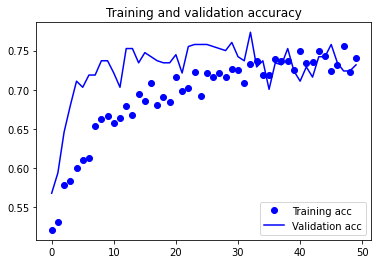

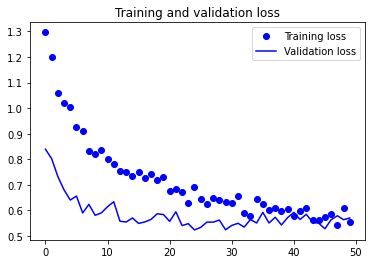

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### **Fine Tuning last Multiply Layer**

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_15':
        set_trainable = True
        print('yay')
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

yay


In [ ]:
# Printing out the layers 
for (i,layer) in enumerate(conv_base.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.name, layer.trainable)

0 InputLayer input_1 False
1 Conv2D conv2d False
2 BatchNormalization batch_normalization False
3 Swish swish False
4 DepthwiseConv2D depthwise_conv2d False
5 BatchNormalization batch_normalization_1 False
6 Swish swish_1 False
7 Lambda lambda False
8 Conv2D conv2d_1 False
9 Swish swish_2 False
10 Conv2D conv2d_2 False
11 Activation activation False
12 Multiply multiply False
13 Conv2D conv2d_3 False
14 BatchNormalization batch_normalization_2 False
15 Conv2D conv2d_4 False
16 BatchNormalization batch_normalization_3 False
17 Swish swish_3 False
18 DepthwiseConv2D depthwise_conv2d_1 False
19 BatchNormalization batch_normalization_4 False
20 Swish swish_4 False
21 Lambda lambda_1 False
22 Conv2D conv2d_5 False
23 Swish swish_5 False
24 Conv2D conv2d_6 False
25 Activation activation_1 False
26 Multiply multiply_1 False
27 Conv2D conv2d_7 False
28 BatchNormalization batch_normalization_5 False
29 Conv2D conv2d_8 False
30 BatchNormalization batch_normalization_6 False
31 Swish swish_6 Fals

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

path = "/content/drive/MyDrive/Trained Models/Face/EfficientNetB0_New2.h5"

checkpoint = ModelCheckpoint(path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

callbacks = [checkpoint]

###**Fine Tune Training**

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.0001),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

In [ ]:
model.save(path)

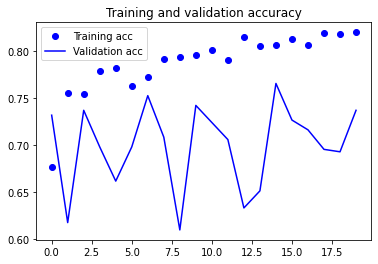

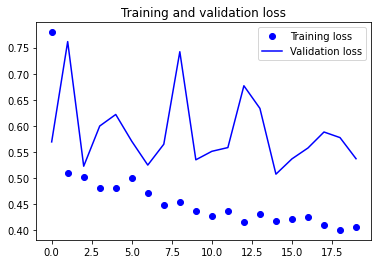

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## **Report**

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip uninstall h5py
!pip install h5py==2.10.0

Uninstalling h5py-3.1.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/h5py-3.1.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libaec-9c9e97eb.so.0.0.10
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5-00e8fae8.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5_hl-383c339f.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libsz-e7aa62f5.so.2.0.1
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libz-eb09ad1d.so.1.2.3
    /usr/local/lib/python3.7/dist-packages/h5py/*
Proceed (y/n)? y
  Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 2.9MB 7.6MB/s 


In [ ]:
!pip install keras_efficientnets

In [ ]:
import numpy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from keras_efficientnets import custom_objects

# print(custom_objects.get_custom_objects())

model = load_model('/content/drive/MyDrive/Trained Models/Face/EfNetB0 tryat1830 3rdMarch.h5')

test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    '/content/drive/MyDrive/Sleepy or Awake Faces - Dataset/validation',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
# predicted_classes = numpy.argmax(predictions, axis=1)

print(predictions)

ValueError: ignored

In [ ]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())  

In [ ]:
from sklearn import metrics

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

              precision    recall  f1-score   support

       awake       0.50      1.00      0.67       200
      sleepy       0.00      0.00      0.00       200

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
